In [175]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from scipy import stats
import numpy as np

Whenever we analyze a random sample of a population, our goal is to draw robust conclusions about the whole population, despite the fact that we can measure only part of it. We must guard against being misled by the inevitable random variations in a sample. It is possible that a sample has very different characteristics than the population itself, but those samples are unlikely. It is much more typical that a random sample, especially a large simple random sample, is representative of the population. More importantly, the chance that a sample resembles the population is something that we know in advance, based on how we selected our random sample. Statistical inference is the practice of using this information to make precise statements about a population based on a random sample.

## Statistics and Parameters

The [Bay Area Bike Share](http://www.bayareabikeshare.com/) service published a [dataset](http://www.bayareabikeshare.com/open-data) describing every bicycle rental from September 2014 to August 2015 in their system. This set of all trips is a population, and fortunately we have the data for each and every trip rather than just a sample. We'll focus only on the *free trips*, which are trips that last less than 1800 seconds (half an hour).

In [176]:
free_trips = Table.read_table("trip.csv").where('Duration', are.below(1800)).select([3, 6, 1])
free_trips

Start Station,End Station,Duration
Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th),765
San Antonio Shopping Center,Mountain View City Hall,1036
Post at Kearny,2nd at South Park,307
San Jose City Hall,San Salvador at 1st,409
Embarcadero at Folsom,Embarcadero at Sansome,789
Yerba Buena Center of the Arts (3rd @ Howard),San Francisco Caltrain (Townsend at 4th),293
Embarcadero at Folsom,Embarcadero at Sansome,896
Embarcadero at Sansome,Steuart at Market,255
Beale at Market,Temporary Transbay Terminal (Howard at Beale),126
Post at Kearny,South Van Ness at Market,932


A quantity measured for a whole population is called a *parameter*. For example, the average duration for any free trip between September 2014 to August 2015 can be computed exactly from these data: 550.00.

In [177]:
np.average(free_trips.column('Duration'))

550.00143345658103

Although we have information for the full population, we will investigate what we can learn from a simple random sample. Below, we sample 100 trips without replacement from `free_trips` not just once, but 40 different times. All 4000 trips are stored in a table called `samples`.

In [178]:
n = 100
samples = Table(['Sample #', 'Duration'])
for i in np.arange(40):
    for trip in free_trips.sample(n).rows:
        samples.append([i, trip.item('Duration')])
samples

Sample #,Duration
0,269
0,662
0,247
0,594
0,756
0,1085
0,559
0,143
0,191
0,227


A quantity measured for a sample is called a *statistic*. For example, the average duration of a free trip in a sample is a statistic, and we find that there is some variation across samples.

In [179]:
for i in np.arange(3):
    sample_average = np.average(samples.where('Sample #', i).column('Duration'))
    print("Average duration in sample", i, "is", sample_average)

Average duration in sample 0 is 577.79
Average duration in sample 1 is 602.45
Average duration in sample 2 is 575.95


Often, the goal of analysis is to estimate parameters from statistics. Proper statistical inference involves more than just picking an estimate: we should also say something about how confident we should be in that estimate. A single guess is rarely sufficient to make a robust conclusion about a population. We also need to quantify in some way how precise we believe that guess to be. 

Already we can see from the example above that the average duration of a sample is around 550, the parameter. Our goal is to quantify this notion of *around*, and one way to do so is to state a range of values.

## Error in Estimates

We can learn a great deal about the behavior of a statistic by computing it for many samples. In the scatter diagram below, the order in which the statistic was computed appears on the horizontal axis, and the value of the average duration for a sample of `n` trips appears on the vertical axis. 

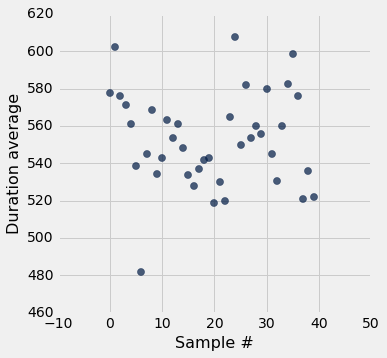

In [180]:
samples.group(0, np.average).scatter(0, 1, s=50)

The sample number doesn't tell us anything beyond when the sample was selected, and we can see from this unstructured cloud of points that one sample does not affect the next in any consistent way. The sample averages are indeed all around 550. Some are above, and some are below.

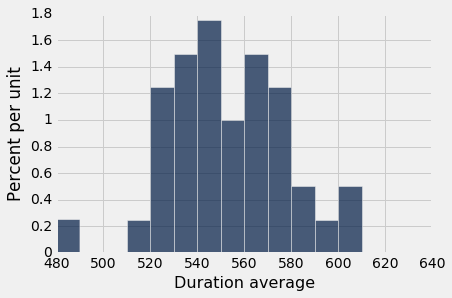

In [181]:
samples.group(0, np.average).hist(1, bins=np.arange(480, 641, 10))

There are 40 averages for 40 samples. If we find an interval that contains 38 out of 40, it will contain 95% of the samples. One such interval is bounded by the second smallest and the second largest sample averages among the 40 samples.

In [182]:
averages = np.sort(samples.group(0, np.average).column(1))
lower = averages.item(1)
upper = averages.item(38)
print('Empirically, 95% of sample averages fell within the interval', lower, 'to', upper)

Empirically, 95% of sample averages fell within the interval 518.9 to 602.45


Given that we know the true parameter is 550, we can make a related statement about this particular collection of 40 samples.

In [183]:
max_deviation = np.ceil(max(550-lower, upper-550))
print('Empirically, for 95% of samples, the sample average was within', 
      max_deviation, 'of the true average')

Empirically, for 95% of samples, the sample average was within 53.0 of the true average


This statement gives us our first notion of a margin of error. If this statement were to hold up not just for our 40 samples, but for all samples, then a reasonable strategy for estimating the true population average would be to draw a 100-trip sample, compute its sample average, and guess that the true average was within `max_deviation` of this quantity. We would be right at least 95% of the time.

The problem with this approach is that finding the `max_deviation` required drawing many different samples, and we would like to be able to say something similar after having collected only one 100-trip sample.

### Variability Within Samples 

By contrast, The individual durations in the samples themselves are not closely clustered around 550. Instead, they span the whole range from 0 to 1800. The durations for the first three 100-item samples are visualized below. All have somewhat similar shapes; they were drawn from the same population. 

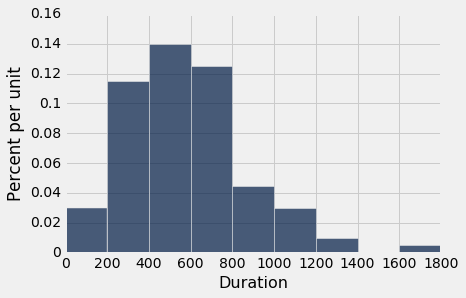

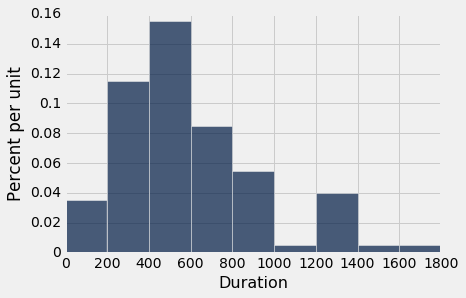

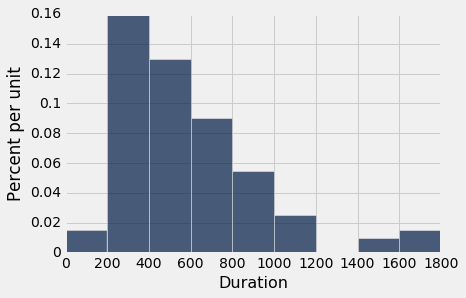

In [184]:
for i in np.arange(3):
    samples.where('Sample #', i).hist(1, bins=np.arange(0, 1801, 200))

We have now observed two different ways in which the variation of a random sample can be observed: the statistics computed from those samples vary in magnitude, and the sampled quantities themselves vary in distribution. That is, there is variability *across samples*, which we see by comparing sample averages, and there is variability *within each sample*, which we see in the duration histograms above.

## Confidence Intervals

Inference begins with a population: a collection that you can describe but often cannot measure directly. One thing we can often do with a populuation is to draw a simple random sample. By measuring a statistic of the sample, we may hope to estimate a parameter of the population. In this process, the population is not random, nor are its parameters. The sample is random, and so is its statistic. The whole process of estimation therefore gives a random result. It starts from a population (fixed), draws a sample (random), computes a statistic (random), and then estimates the parameter from the statistic (random). By calling the process random, we mean that the final estimate could have been different because the sample could have been different.

A confidence interval is one notion of a margin of error around an estimate. The margin of error acknowledges that the estimation process could have been misleading because of the variation in the sample. It gives a range that might contain the original parameter, along with a percentage of confidence. For example, a 95% confidence interval is one in which we would expect the interval to contain the true parameter for 95% of random samples. For any particular sample, any particular estimate, and any particular interval, the parameter is either contained or not; we never know for sure. The purpose of the confidence interval is to quantify how often our estimation process gives us a range containing the truth.

There are many different ways to compute a confidence interval. The challenge in computing a confidence interval from a single sample is that we don't know the population, and so we don't know how its samples will vary. One way to make progress despite this limited information is to assume that the variability *within the sample* is similar to the variability within the population.

### Resampling from a Sample

Even though we happen to have the whole population of `free_trips`, let's imagine for a moment that we have only a single 100-trip sample from this population. That sample has 100 durations. Our goal now is to learn what we can about the population using just this sample.

In [185]:
sample = samples.where("Sample #", 0)
sample_average = np.average(sample.column('Duration'))
sample_average

577.78999999999996

A technique called *bootstrap resampling* uses the variability of the sample as a proxy for the variability of the population. Instead of drawing many samples from the population, we will draw many samples from the sample. Since the original sample and the re-sampled sample have the same size, we must draw with replacement in order to see any variability at all. 

In [186]:
resamples = Table(['Resample #', 'Duration'])
for i in np.arange(40):
    for trip in sample.sample(n, with_replacement=True).rows:
        resamples.append([i, trip.item('Duration')])
resamples

Resample #,Duration
0,1085
0,391
0,199
0,1216
0,1050
0,501
0,227
0,376
0,560
0,532


Using the `resamples`, we can investigate the variability of the corresponding sample averages.

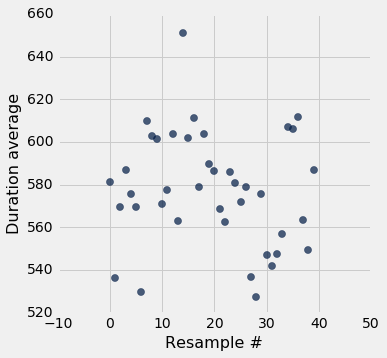

In [187]:
resamples.group(0, np.average).scatter(0, 1, s=50)

These sample averages are not necessarily clustered around the true average 550. Instead, they will be clustered around the average of the sample from which they were re-sampled.

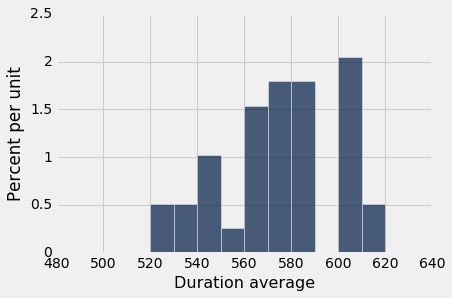

In [188]:
resamples.group(0, np.average).hist(1, bins=np.arange(480, 641, 10))

Although the center of this distribution is not the same as the true population average, the spread is similar. We use as our confidence interval around the sample average the max deviation among the 95% (38 out of 40) that exclude the most extreme values.

In [189]:
averages = np.sort(resamples.group(0, np.average).column(1))
lower = averages.item(1)
upper = averages.item(38)
print('A 95% confidence interval:', lower, 'to', upper)

A 95% confidence interval: 529.91 to 611.87


It is also reasonable to center the interval around the sample average by computing the max deviation within this interval.

In [190]:
max_deviation = max(sample_average-lower, upper-sample_average)
print('Another 95% confidence interval:', sample_average, '+/-', max_deviation)

Another 95% confidence interval: 577.79 +/- 47.88


### Evaluating Confidence Intervals

When given only a sample, it is not possible to check whether the parameter was estimated correctly. However, in the case of the Bay Area Bike Share, we have not only the sample, but many samples and the whole population. Therefore, we can check how often the confidence intervals we compute in this way do in fact contain the true parameter.

Before measuring the accuracy of our technique, we can visualize the result of resampling each sample. The following scatter diagram has 40 vertical lines for 40 samples, and each line consists of 40 points for 40 resampled means.

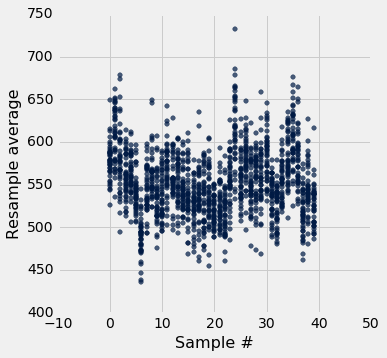

In [202]:
resample_averages = Table(['Sample #', 'Resample average'])
for i in np.arange(40):
    sample = samples.where('Sample #', i)
    for j in np.arange(40):
        resample = sample.sample(n, with_replacement=True)
        resample_average = np.average(resample.column('Duration'))
        resample_averages.append([i, resample_average])
resample_averages.scatter(0, 1, s=20)

We can see from the plot above that for almost every sample, there are some resampled averages above 550 and some below. When we use these resampled averages to compute confidence intervals, many of those intervals contain 550 as a result. Below, the `Lower` bounds of the confidence intervals for almost all of the samples are below the true average 550. Likewise, the `Upper` bounds are almost always above 550. We have a process for computing confidence intervals that almost always finds an interval containing the truth.

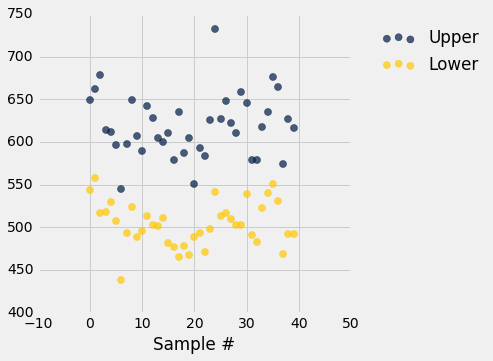

In [216]:
lowers = resample_averages.group('Sample #', percentile(2.5))
uppers = resample_averages.group('Sample #', percentile(97.5))
intervals = uppers.join('Sample #', lowers).relabeled(1, 'Upper').relabeled(2, 'Lower')
intervals.scatter(0, s=50)

We can compute precisely which intervals contain the truth, and we find that about 95% of them do. Since we resampled only a small number of times (10,000 resamples is much more typical than 40 for computing 95% confidence intervals) and began with fairly small samples of size 100, we may find that a few more than 2 out of the 40 confidence intervals failed to contain the truth.

In [214]:
np.logical_and(intervals.column('Lower') <= 550, 
               intervals.column('Upper') >= 550)

array([ True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True], dtype=bool)

Each confidence interval is generated from only a single sample of 100 trips. As a result, the width of the interval varies quite a bit as well. Compared to the interval width we computed originally (which required multiple samples), we see that some of these intervals are much more narrow and some are much wider. 

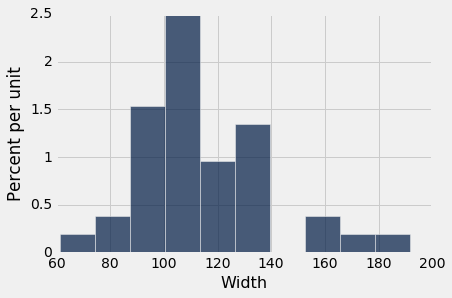

In [207]:
Table().with_column('Width', intervals.column('Upper')-intervals.column('Lower')).hist(0)

Given a single sample, it is impossible to know whether you have correctly estimated the parameter or not. However, you can infer a precise notion of confidence by following a process based on random sampling.